<h1>Data Preprocessing for Neural Networks</h1>

<h2>Amogh S. Inamdar</h2>
<h6></h6>
For a guest lesson in Data Mining (CSE01) at Ramaiah Institute of Technology

<blockquote>
    
   Here, we use a Cardiovascular Disease dataset, sourced from Kaggle.
   
   <blockquote>Find the dataset <a href=https://www.kaggle.com/sulianova/eda-cardiovascular-data/data>here</a></blockquote>
    
   Libraries used:
   <blockquote>
   <a href=https://matplotlib.org/>Matplotlib</a>
     
   <a href=https://seaborn.pydata.org/>Seaborn</a>
     
   <a href=https://scikit-learn.org/stable/>Scikit-Learn</a>
   
   <a href=https://www.tensorflow.org/>TensorFlow</a> 
   
   <a href=https://keras.io>Keras</a>
   </blockquote>
   
</blockquote>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, SelectKBest

import keras as kr
from keras.models import Sequential
from keras.layers import Dense

df = pd.read_csv("cardio_train.csv")

# print(df.shape) # samples X attributes
print("CVD Positive: ", df[df['cardio']==1].shape[0]) # number of samples with cardiovascular disease

df = df.sample(10000, random_state=1)

print("CVD Positive in sample: ", df[df['cardio']==1].shape[0])   # number of elements with cardiovascular disease
df.head()

X = df[['gender', 'smoke', 'alco', 'active', 
             'age', 'height', 'weight', 'ap_hi', 'ap_lo',
            'gluc', 'cholesterol']].values
Y = df['cardio'].values

Using TensorFlow backend.


CVD Positive:  34979
CVD Positive in sample:  5049



<h2>Validating Your Data</h2>
    
Data often contains missing/invalid values, or values in ranges that do not make sense.
    
<blockquote>In this dataset, age is represented in days. Let's convert it to (365-day) years.</blockquote>

In [2]:
df['age'] = df['age']/365
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6670,9510,44.106849,1,153,93.0,140,90,1,1,0,0,1,1
49567,70773,39.553425,1,157,89.0,120,80,1,1,0,0,1,1
50796,72486,54.353425,1,165,66.0,150,90,1,1,0,0,1,1
22310,31877,49.452055,2,176,88.0,160,100,2,2,1,1,1,1
54037,77086,46.079452,2,165,78.0,140,90,1,1,0,0,0,1


<blockquote>Missing values can affect performance and correctness. Thankfully, this dataset is devoid of any

In [3]:
print("Missing values exist? ", df.isnull().values.any())

Missing values exist?  False


<blockquote>Outliers can grossly diminish model performance. To detect and remove outliers, we use boxplots here.
    
    One approach would be to keep only the data that falls within the IQR. However, this could lead to eliminating a large number of useful samples.
    
    However, values that are out of range of the boxplot whiskers are almost certainly outliers. 
    Here, we keep 95%  of the data, discarding the extremum percentiles (95% ~ upto 2 standard deviations away from the mean).

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5e736bd4a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5e736bdb38>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5e736bd080>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5e736bdf60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5e7364f550>,
 'means': []}

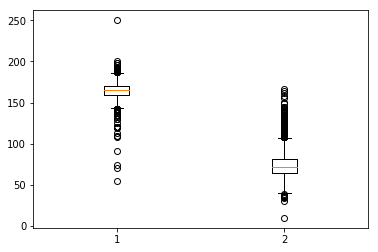

In [4]:
plt.boxplot([df['height'], df['weight']])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5e735f0780>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5e735f0e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5e735f0390>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5e735f94e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5e735f9828>,
 'means': []}

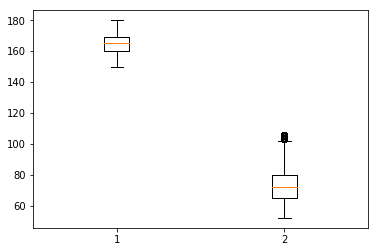

In [5]:
#Removing invalid weights and heights
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

plt.boxplot([df['height'], df['weight']])

<blockquote>Some attributes can have values that may seem plausible, but cannot be right taking other attributes into account. Detecting this kind of information usually requires prior knowledge of the data and the research domain. 
    
    Here, some samples have values of Systolic BP (ap_hi) lower than that of Diastolic BP (ap_lo). 
    This is nonsensical from a biological standpoint.
    
    One approach would be to simply swap the values to account for mistakes in data entry, but this would add bias to the model that might not be correct. 
    Here, we simply discard such samples.
    
    Having equal/nearly equal values of ap_hi and ap_lo would also be invalid, but we do not address this issue here.

Diastolic pressure is higher than systolic one in 162 cases


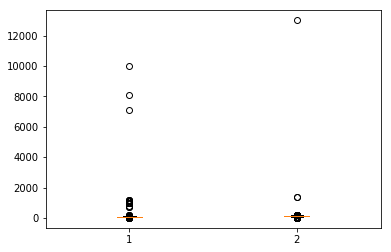

In [6]:
#Removing invalid BP
plt.boxplot([df['ap_lo'], df['ap_hi']])
print("Diastolic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastolic pressure is higher than systolic one in 0 cases


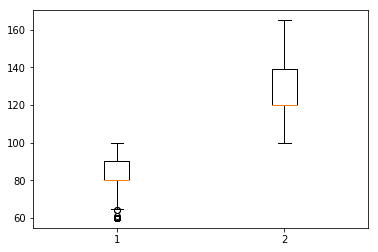

In [7]:
#Removing outliers
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

plt.boxplot([df['ap_lo'], df['ap_hi']])
print("Diastolic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

<h2>Analysing the Effects of the Data Attributes</h2> 

/home/amogh/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


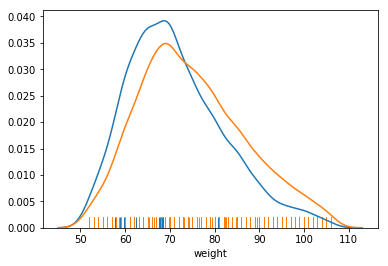

In [8]:
sns.distplot(df[df['cardio']==0]['weight'], hist=False, rug=True)
sns.distplot(df[df['cardio']==1]['weight'], hist=False, rug=True)

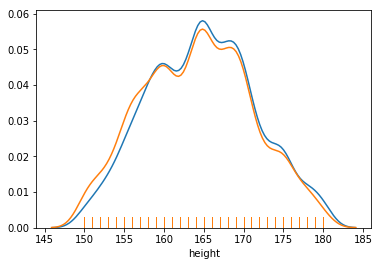

In [9]:
sns.distplot(df[df['cardio']==0]['height'], hist=False, rug=True)
sns.distplot(df[df['cardio']==1]['height'], hist=False, rug=True)

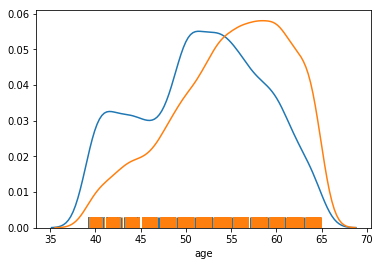

In [10]:
sns.distplot(df[df['cardio']==0]['age'], hist=False, rug=True)
sns.distplot(df[df['cardio']==1]['age'], hist=False, rug=True)

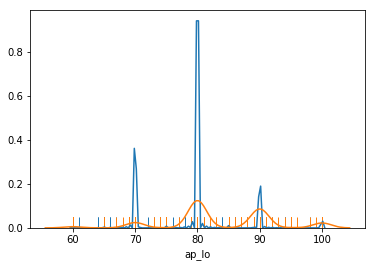

In [11]:
sns.distplot(df[df['cardio']==0]['ap_lo'], hist=False, rug=True)
sns.distplot(df[df['cardio']==1]['ap_lo'], hist=False, rug=True)

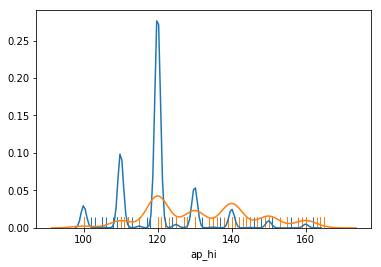

In [12]:
sns.distplot(df[df['cardio']==0]['ap_hi'], hist=False, rug=True)
sns.distplot(df[df['cardio']==1]['ap_hi'], hist=False, rug=True)

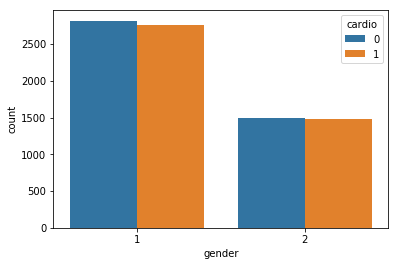

In [13]:
sns.countplot(x='gender', hue='cardio', data=df)

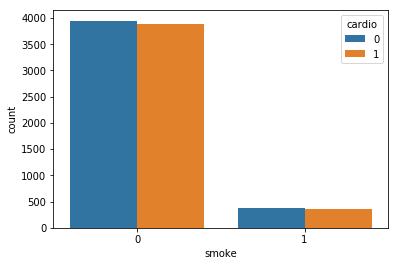

In [14]:
sns.countplot(x='smoke', hue='cardio', data=df)

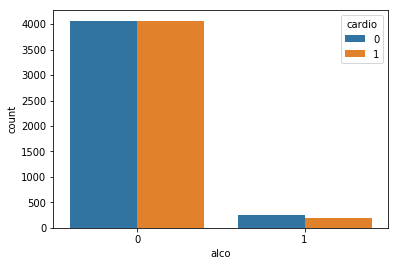

In [15]:
sns.countplot(x='alco', hue='cardio', data=df)

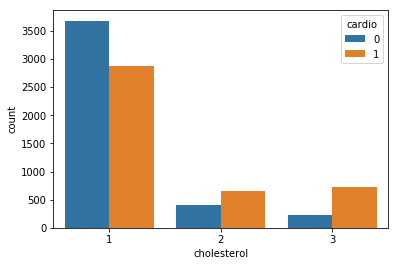

In [16]:
sns.countplot(x='cholesterol', hue='cardio', data=df)

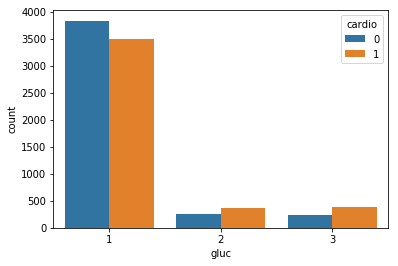

In [17]:
sns.countplot(x='gluc', hue='cardio', data=df)

<h2>A Preliminary Classification Model</h2>

In [18]:
model = Sequential()
model.add(Dense(15, input_dim=11, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=10, batch_size=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
10000/10000 [==============================] - 1s 88us/step - loss: 0.2521 - acc: 0.4999
Epoch 2/10
10000/10000 [==============================] - 1s 68us/step - loss: 0.2513 - acc: 0.5034
Epoch 3/10
10000/10000 [==============================] - 1s 59us/step - loss: 0.2513 - acc: 0.5008
Epoch 4/10
10000/10000 [==============================] - 1s 60us/step - loss: 0.2517 - acc: 0.4914
Epoch 5/10
10000/10000 [==============================] - 1s 63us/step - loss: 0.2515 - acc: 0.4963
Epoch 6/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.2516 - acc: 0.4961
Epoch 7/10
10000/10000 [==============================] - 1s 78us/step - loss: 0.2515 - acc: 0.4993
Epoch 8/10
10000/10000 [==============================] - 1s 114us/step - loss: 0.2520 - acc: 0.4853
Epoch 9/10
10000/10000 [==============================] - 1s 124us/step - loss

<h2>Wait, WHAT!!! Aren't Neural Networks supposed to be good at classification???</h2>

Short Answer: Yes, if you do them right.

Long(er) Answer:
<blockquote>Neural networks are great, but in the end, they have stastical constraints too.
    
   If features lie on different scales and are correlated, the network can have trouble approximating the function required to classify.
   
   To mitigate this, the data must be scaled, and ideally, decorrelated</blockquote>

[[ 44.10684932 153.          93.         140.          90.        ]
 [ 39.55342466 157.          89.         120.          80.        ]
 [ 54.35342466 165.          66.         150.          90.        ]
 [ 49.45205479 176.          88.         160.         100.        ]
 [ 46.07945205 165.          78.         140.          90.        ]
 [ 57.60821918 160.          62.         160.          90.        ]
 [ 53.96164384 169.          98.         120.          70.        ]
 [ 50.81917808 160.          67.         120.          80.        ]
 [ 45.65753425 166.          66.         130.          90.        ]
 [ 39.86849315 155.          61.         110.          70.        ]]


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5e687a95f8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5e687a9c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5e687a91d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5e687b2390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5e687b2668>,
 'means': []}

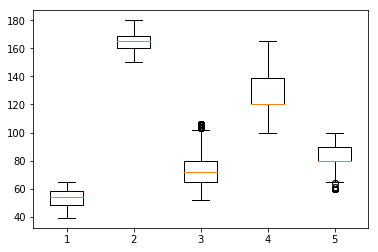

In [19]:
originals = stdnums = df[['age', 'height', 'weight','ap_hi', 'ap_lo']].values
print(stdnums[:10,])
plt.boxplot(stdnums)

As seen, the values of the numeric attributes lie on different scales.
<blockquote>To mitigate this, we use z-score standardization.
   All data is brought to a zero-mean, unit-variance range</blockquote>

[[-1.38037558 -1.68802568  1.73292481  1.0182685   1.08306841]
 [-2.06074818 -1.10122609  1.38336409 -0.42559351 -0.13352704]
 [ 0.15066745  0.07237309 -0.62661005  1.74019951  1.08306841]
 [-0.58169511  1.68607197  1.29597391  2.46213052  2.29966386]
 [-1.08562933  0.07237309  0.42207211  1.0182685   1.08306841]
 [ 0.63699877 -0.6611264  -0.97617077  2.46213052  1.08306841]
 [ 0.09212757  0.65917268  2.1698757  -0.42559351 -1.35012248]
 [-0.37741958 -0.6611264  -0.53921987 -0.42559351 -0.13352704]
 [-1.14867227  0.21907299 -0.62661005  0.2963375   1.08306841]
 [-2.01367065 -1.39462589 -1.06356095 -1.14752452 -1.35012248]]


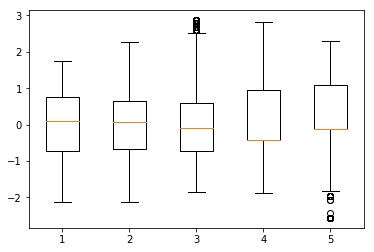

In [20]:
scaler = StandardScaler()
scaler.fit(stdnums)
stdnums = scaler.transform(stdnums)
plt.boxplot(stdnums)
print(stdnums[:10,])

In [21]:
X = np.hstack((stdnums, df[['gender', 'smoke', 'alco', 'active', 'gluc', 'cholesterol']].values))

X.shape

(8560, 11)

In [23]:
Y = df['cardio'].values

model = Sequential()
model.add(Dense(15, input_dim=11, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=10, batch_size=10)

Epoch 1/10
8560/8560 [==============================] - 1s 75us/step - loss: 0.2016 - acc: 0.7020
Epoch 2/10
8560/8560 [==============================] - 1s 63us/step - loss: 0.1908 - acc: 0.7181
Epoch 3/10
8560/8560 [==============================] - 1s 69us/step - loss: 0.1891 - acc: 0.7201
Epoch 4/10
8560/8560 [==============================] - 1s 58us/step - loss: 0.1880 - acc: 0.7257
Epoch 5/10
8560/8560 [==============================] - 0s 58us/step - loss: 0.1871 - acc: 0.7200
Epoch 6/10
8560/8560 [==============================] - 0s 58us/step - loss: 0.1868 - acc: 0.7216
Epoch 7/10
8560/8560 [==============================] - 1s 71us/step - loss: 0.1867 - acc: 0.7222
Epoch 8/10
8560/8560 [==============================] - 0s 58us/step - loss: 0.1861 - acc: 0.7237
Epoch 9/10
8560/8560 [==============================] - 1s 59us/step - loss: 0.1860 - acc: 0.7237
Epoch 10/10
8560/8560 [==============================] - 1s 59us/step - loss: 0.1858 - acc: 0.7237


<h2>Much Better Already! But are so many variables really necessary?</h2>

<blockquote>To analyse the importance of variables and whether they're necessary, we use correlation plots</blockquote>

In [24]:
df_for_correlation = pd.DataFrame(X)
df_for_correlation.columns = ['age', 'height', 'weight','ap_hi', 'ap_lo', 'gender', 
                              'smoke', 'alco', 'active', 'gluc', 'cholesterol']
corr_matrix = df_for_correlation.corr()
corr_matrix

,age,height,weight,ap_hi,ap_lo,gender,smoke,alco,active,gluc,cholesterol
age,1.000000,-0.083903,0.053429,0.191287,0.132361,-0.026701,-0.046362,-0.044056,-0.010371,0.092814,0.139008
height,-0.083903,1.000000,0.247847,-0.002174,0.013723,0.494978,0.177548,0.070126,-0.014750,-0.050256,-0.079259
weight,0.053429,0.247847,1.000000,0.221661,0.197556,0.120449,0.041311,0.056455,-0.017928,0.069674,0.130155
ap_hi,0.191287,-0.002174,0.221661,1.000000,0.688481,0.062576,0.036363,0.013306,-0.000033,0.083884,0.179187
ap_lo,0.132361,0.013723,0.197556,0.688481,1.000000,0.058813,0.033675,0.019148,0.005129,0.059667,0.135136
gender,-0.026701,0.494978,0.120449,0.062576,0.058813,1.000000,0.328596,0.153337,0.003897,-0.028810,-0.035484
smoke,-0.046362,0.177548,0.041311,0.036363,0.033675,0.328596,1.000000,0.334195,0.024971,-0.013940,0.014785
alco,-0.044056,0.070126,0.056455,0.013306,0.019148,0.153337,0.334195,1.000000,0.028060,0.004190,0.013996
active,-0.010371,-0.014750,-0.017928,-0.000033,0.005129,0.003897,0.024971,0.028060,1.000000,-0.013869,0.007035
gluc,0.092814,-0.050256,0.069674,0.083884,0.059667,-0.028810,-0.013940,0.004190,-0.013869,1.000000,0.468379


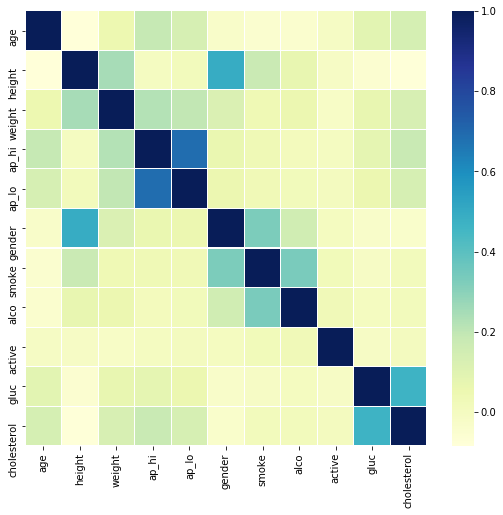

In [25]:
fig, ax = plt.subplots(figsize = (9, 8))
sns.heatmap(corr_matrix, ax=ax, cmap='YlGnBu', linewidths=0.1)

<blockquote>The predictor variables are mostly uncorrelated here. That's great!. 
    
    Only the blood pressure and blood content variables seem to be strongly correlated.
    
    Also, as per the analysis before, most of the variables don't seem to influence the target class at all!
    Let us now take this into account.
    
    IF the data were to be correlated, a great way to decorrelate it would be to use PCA as shown.
   </blockquote>

Variance per component:  [0.30301111 0.20170132 0.14673686 0.11778723 0.08145872 0.04905031
 0.03061353 0.02715344 0.02472202 0.01174654 0.00601892] 

Singular Values:  [127.52698548 104.04643027  88.74469882  79.51003026  66.12133322
  51.30901751  40.53493567  38.17554817  36.42628009  25.10890212
  17.97347676]

Using only 85% of the energy in the matrix:

Variance per component:  [0.30301111 0.20170132 0.14673686 0.11778723 0.08145872] 

Singular Values:  [127.52698548 104.04643027  88.74469882  79.51003026  66.12133322] 

[[ 1.35240608 -0.26622555  1.57801964  2.18824707 -1.0240855 ]
 [-0.5621497   0.54100297  1.4542468   2.1602634  -0.67662849]
 [ 1.52446392 -0.66091763  0.84699354 -0.92507482 -0.31532276]
 ...
 [ 0.30878782  0.82976796 -1.55707308 -0.43104259 -0.51247536]
 [-0.51923267 -0.54242998  0.43178362  1.13557778 -0.6636885 ]
 [ 0.63097598 -1.57592225  0.7642924   0.51360707  0.737345  ]]


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5e680a2438>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5e680a2ac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5e680a2048>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5e680a2ef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5e680aa4e0>,
 'means': []}

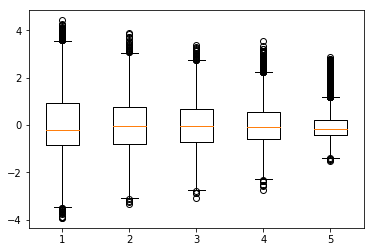

In [26]:
pca = PCA(n_components=11)
pca.fit(X)

print("Variance per component: ", pca.explained_variance_ratio_, "\n")
print("Singular Values: ", pca.singular_values_)

print("\nUsing only 85% of the energy in the matrix:\n")

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

print("Variance per component: ", pca.explained_variance_ratio_, "\n")
print("Singular Values: ", pca.singular_values_, "\n")
print(X_pca)
plt.boxplot(X_pca)

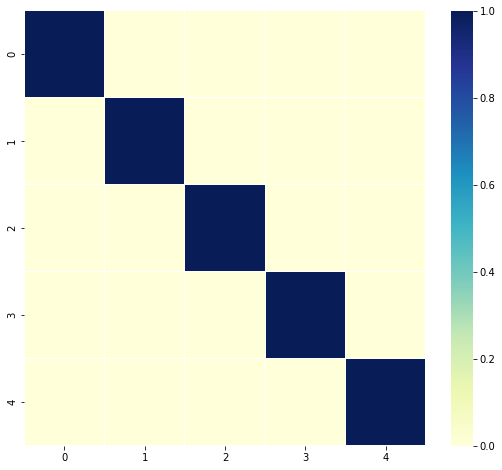

In [27]:
df_pca_corr = pd.DataFrame(X_pca)
corr_post_pca = df_pca_corr.corr()

fig, ax = plt.subplots(figsize = (9, 8))
sns.heatmap(corr_post_pca, ax=ax, cmap='YlGnBu', linewidths=0.1)

In [28]:
model = Sequential()
model.add(Dense(15, input_dim=5, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_pca, Y, epochs=10, batch_size=10)

Epoch 1/10
8560/8560 [==============================] - 1s 89us/step - loss: 0.2284 - acc: 0.6757
Epoch 2/10
8560/8560 [==============================] - 1s 71us/step - loss: 0.2006 - acc: 0.7040
Epoch 3/10
8560/8560 [==============================] - 1s 63us/step - loss: 0.1975 - acc: 0.7111
Epoch 4/10
8560/8560 [==============================] - 1s 63us/step - loss: 0.1954 - acc: 0.7099
Epoch 5/10
8560/8560 [==============================] - 1s 59us/step - loss: 0.1937 - acc: 0.7112
Epoch 6/10
8560/8560 [==============================] - 1s 66us/step - loss: 0.1928 - acc: 0.7114
Epoch 7/10
8560/8560 [==============================] - 1s 60us/step - loss: 0.1924 - acc: 0.7125
Epoch 8/10
8560/8560 [==============================] - 1s 75us/step - loss: 0.1920 - acc: 0.7127
Epoch 9/10
8560/8560 [==============================] - 1s 60us/step - loss: 0.1922 - acc: 0.7121
Epoch 10/10
8560/8560 [==============================] - 1s 62us/step - loss: 0.1913 - acc: 0.7114


Fantastic! The model predicts with almost the same level of accuracy as before, but using only 5 input variables!
<blockquote>These variables are the principal components that account for around 85% of the variance in the dataset.
    
    However, do we even need to use these components? Selecting useful attributes directly might do the job too.
    
    To do this, we use the chi-squared test. The attributes must be positive numbers for this test, so we use min-max scaling.

[[0.19249125 0.1        0.75925926 0.61538462 0.75      ]
 [0.01622654 0.23333333 0.68518519 0.30769231 0.5       ]
 [0.58913989 0.5        0.25925926 0.76923077 0.75      ]
 [0.39940609 0.86666667 0.66666667 0.92307692 1.        ]
 [0.26885142 0.5        0.48148148 0.61538462 0.75      ]
 [0.71513416 0.33333333 0.18518519 0.92307692 0.75      ]
 [0.57397391 0.63333333 0.85185185 0.30769231 0.25      ]
 [0.45232792 0.33333333 0.27777778 0.30769231 0.5       ]
 [0.25251882 0.53333333 0.25925926 0.46153846 0.75      ]
 [0.02842295 0.16666667 0.16666667 0.15384615 0.25      ]] 

 (8560, 5)


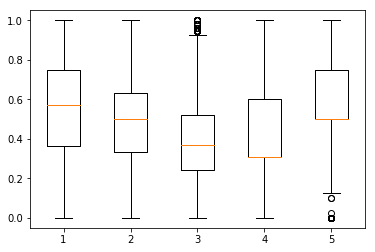

In [29]:
# min-max scaling for values > 0 required by chi-square
scaler = MinMaxScaler()
scaler.fit(originals)
nums = scaler.transform(originals)
plt.boxplot(nums)
print(nums[:10,], "\n\n", nums.shape)

In [30]:
X = np.hstack((nums, df[['gender', 'smoke', 'alco', 'active', 'gluc', 'cholesterol']].values))

X_best = SelectKBest(chi2, k=2).fit_transform(X, Y)
cols = SelectKBest(chi2, k=2).fit(X, Y).get_support(indices=True)
cols

array([ 3, 10])

<blockquote>Here, we've considered only 2 of the best factors! (turns out they are ap_hi and cholesterol)
    
    Taking more than 2 variables results in selecting correlated variables, for this dataset. 
    Believe me, I've checked :)
   </blockquote>

In [31]:
model = Sequential()
model.add(Dense(15, input_dim=2, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_best, Y, epochs=10, batch_size=10)

Epoch 1/10
8560/8560 [==============================] - 1s 89us/step - loss: 0.2681 - acc: 0.6165
Epoch 2/10
8560/8560 [==============================] - 1s 65us/step - loss: 0.2026 - acc: 0.7125
Epoch 3/10
8560/8560 [==============================] - 1s 71us/step - loss: 0.1991 - acc: 0.7151
Epoch 4/10
8560/8560 [==============================] - 1s 70us/step - loss: 0.1991 - acc: 0.7140
Epoch 5/10
8560/8560 [==============================] - 1s 87us/step - loss: 0.1988 - acc: 0.7140
Epoch 6/10
8560/8560 [==============================] - 1s 77us/step - loss: 0.1988 - acc: 0.7157
Epoch 7/10
8560/8560 [==============================] - 1s 64us/step - loss: 0.1989 - acc: 0.7147
Epoch 8/10
8560/8560 [==============================] - 1s 61us/step - loss: 0.1988 - acc: 0.7159
Epoch 9/10
8560/8560 [==============================] - 1s 67us/step - loss: 0.1985 - acc: 0.7151
Epoch 10/10
8560/8560 [==============================] - 1s 69us/step - loss: 0.1986 - acc: 0.7144


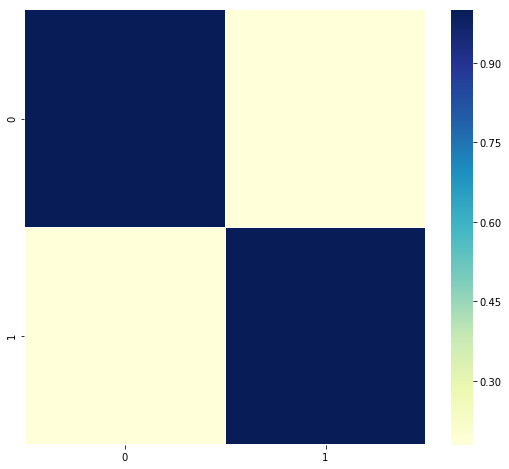

In [32]:
df_best_corr = pd.DataFrame(X_best)
corr_post_best = df_best_corr.corr()

fig, ax = plt.subplots(figsize = (9, 8))
sns.heatmap(corr_post_best, ax=ax, cmap='YlGnBu', linewidths=0.1)

<h2>Incredible! Turns out we can get almost the same classification accuracy with just two input variables</h2>

<blockquote>Of course, we could have tested this a lot earlier, but then I wouldn't have been able to bore you for 40 minutes.
    
    Practically, correlated variables are one of the first to go.
    
    Missing values follow suit, or are handled in other ways.
    
    The data is transformed to suit the model being built, and then we're ready to go!
   </blockquote>
   
<h2>Know your data. Tranform your data. Learn from it.</h2>